# Предсказании продолжительности деятельности стартапа

На основании данных о стартапах, которые функционировали в период с 1980 по 2018 годы, нужно предсказать какие из них закроются, а какие нет. Дата снятия данных 01 января 2018.

## Описание данных

Данные о стартапах находятся в двух файлах kaggle_startups_train_28062024.csv, kaggle_startups_test_28062024.csv. Также есть файл kaggle_startups_sample_submit_28062024.csv с образцом вывода результата. 

name - название стартапа.  
category_list - отрасль, к которой относится стартап.  
funding_total_usd - сумма инвестиций, которую привлекла компания в долларах.  
country_code - код страны.  
state_code - код региона страны.  
region - регион страны.  
city - город.  
funding_rounds - количество раундов инвестиций.  
first_funding_at - дата первого раунда инвестиций.  
last_funding_at - дата последнего раунда инвестиций.  
lifetime - время существования стартапа в днях.  
status - состояние стартапа (закрыт или действующий).  
closed_at - дата закрытия стартапа.   
founded_at - дата основания.  
closed_at - дата закрытия.  


В процессе работы предстоит изучить полученные данные, провести их предварительную обработку, провести исследовательский анализ данных, провести подготовку признаков в пайплайне и обучить модели.

In [1]:
!pip install -U scikit-learn
!pip install phik -q 

     |████████████████████████████████| 13.4 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 107.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
!pip install shap

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01


In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import (mean_squared_error,  r2_score)
from numpy.random import RandomState
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
import shap
from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

### Загрузка данных

In [4]:
#функция для загрузки датафреймов, с преварительным указанием пути.
def pd_read_csv(file_path,file_name):
    try:
        data = pd.read_csv(file_path + file_name)
        return data
    except FileNotFoundError:
        print(f'Файл {file_name} не найден!')

In [5]:
file_path = ''

In [6]:
#ф-ция для вывода осн.инф-ции по датасетам
def dataset_describe(dataset, head=5):
    dataset.info()
    display(dataset.head(head))

Тренировочная выборка.

In [7]:
train = pd_read_csv(file_path, 'kaggle_startups_train_28062024.csv')

In [8]:
dataset_describe(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


Тестовая выборка.

In [9]:
test = pd_read_csv(file_path, 'kaggle_startups_test_28062024.csv')

In [10]:
dataset_describe(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


В датафрейме train 52516 записей. В большинстве столбцов есть пропуски. Нет пропусков только в столбце status и в четырех столбцах относящихся к инвестиционным раундам. Кроме этого столбцы с датой first_funding_at и last_funding_at имеют тип object.

В датафрейме test 13125 записей. Также как и предыдущем датафрейме пропусков нет в столбцах относящихся к инвестиционным раундам, кроме этого пропусков нет в названии стартапа, столбце name. Столбцы с датой также имеют тип object.

С пропусками и неверными типами данных будем разбираться не следующих этапах.

Кроме этого можно отметить, что несмотря на то, что один датафрейм для обучающих данных, а второй для тестовых, датафремы отличаются друг от друга столбцами founded_at, closed_at, status которые есть только в датафрейме train, и lifetime, который есть только в датафрейме test.

###  Предобработка данных

Найдем явные задвоения в каждом датафрейме, если такие имеются.

In [11]:
train.duplicated().sum()

0

In [12]:
test.duplicated().sum()

0

Явных задвоений нет.

Проверим, содержат ли датафреймы пустые значения.

In [13]:
train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [14]:
test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пустых значений много и они в разных столбцах. 

Рассмотрим строку с пустым названием датафрейма train.

In [15]:
train[train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


Заменим пустое название на unknown.

In [16]:
train.loc[3291, "name"] = "unknown"

Теперь рассмотрим, сколько случаев, когда в оставшихся шести столбцах с пустыми значениями (country_code, state_code, region, city, category_list, funding_total_usd) все эти шесть столбцов пустые.

In [17]:
train[train['country_code'].isna() & train['state_code'].isna() & train['region'].isna() 
      & train['city'].isna() & train['category_list'].isna() & train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaN
78,Efficient Photon,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2010-02-12,2011-09-22,2011-09-22,2013-08-07
155,Public Post,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-03-04,2008-08-14,2008-08-14,2010-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52327,Connexions,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2010-09-24,2012-05-01,2012-05-01,NaN
52377,Maremonti,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2012-05-17,2013-08-01,2013-08-01,NaN
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaN
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30


Таким образом есть 884 стартапа, по которым неизвестно ничего кроме названия, срока работы, который можно определить по датам, и количества инвестиционных раундов.  
Наложим ещё одно условие, выберем те же строки, но с количеством инвестиционных раундов, равных 1.

In [18]:
train[train['country_code'].isna() & train['state_code'].isna() 
      & train['region'].isna() & train['city'].isna() & train['category_list'].isna() 
      & train['funding_total_usd'].isna() & (train['funding_rounds']==1)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaN
78,Efficient Photon,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2010-02-12,2011-09-22,2011-09-22,2013-08-07
155,Public Post,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-03-04,2008-08-14,2008-08-14,2010-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52327,Connexions,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2010-09-24,2012-05-01,2012-05-01,NaN
52377,Maremonti,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2012-05-17,2013-08-01,2013-08-01,NaN
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaN
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30


Количество строк сократилось, но не сильно - 844 строки.
Уже из отображаемых строк видно, что у таких стартапов разный статус. 
Посмотрим более явно, сколько стартапов с одним и другим статусом.

In [19]:
print("Количество закрывшихся стартапов в датасете train:",
    len(train[train['country_code'].isna() & train['state_code'].isna() 
      & train['region'].isna() & train['city'].isna() & train['category_list'].isna() 
      & train['funding_total_usd'].isna() & (train['funding_rounds']==1) & (train['status']=='closed')])
)

Количество закрывшихся стартапов в датасете train: 299


In [20]:
print("Количество работающих стартапов в датасете train:",
    len(train[train['country_code'].isna() & train['state_code'].isna() 
      & train['region'].isna() & train['city'].isna() & train['category_list'].isna() 
      & train['funding_total_usd'].isna() & (train['funding_rounds']==1) & (train['status']=='operating')])
)

Количество работающих стартапов в датасете train: 545


Таким образом у нас в тренировочном датасете есть 844 строки, в которых по сути минимум полезной информации, а именно только срок работы стартапа. Количество инвестиционных раундов, равное единице, полезной информацией считать не получается, поскольку один раунд есть вообще у любого стартапа.

Посмотрим, есть ли такие же случаи в тестовой выборке. 

In [21]:
test[test['country_code'].isna() & test['state_code'].isna() 
      & test['region'].isna() & test['city'].isna() & test['category_list'].isna() 
      & test['funding_total_usd'].isna() & (test['funding_rounds']==1)]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
80,Indie Broadcast Network,NaN,NaN,NaN,NaN,NaN,NaN,1,2013-07-17,2013-07-17,1162
186,Desafío Táctico,NaN,NaN,NaN,NaN,NaN,NaN,1,2013-08-02,2013-08-02,2150
231,Nemo,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-01-28,2015-01-28,951
340,LaunchCenter 39,NaN,NaN,NaN,NaN,NaN,NaN,1,2000-02-03,2000-02-03,654
359,BorderX Lab,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-06-15,2015-06-15,710
...,...,...,...,...,...,...,...,...,...,...,...
12864,PittMoss,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-04-17,2015-04-17,1635
12880,UGIG,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-04-19,2011-04-19,3047
12891,Himily,NaN,NaN,NaN,NaN,NaN,NaN,1,2014-08-20,2014-08-20,936
12992,Maboo,NaN,NaN,NaN,NaN,NaN,NaN,1,2015-07-13,2015-07-13,747


В тестовой выборке такие случаи тоже есть, и их не мало - 1,6%.  

Даже если просто исходить из здравого смысла, предсказание работы/не работы стартапа, исходя только из срока его работы, не может быть точным настолько, чтобы на такую информацию можно было хоть сколько-то всерьез опираться.  
В этой связи я бы удалил подобные строки как из тренировочной, так и из тестовой выборки с комментарием, что для предсказания сначала нужно получить более точную информацию - по отрасли, полученным деньгам, стране и т.д.
Но поскольку необходимо сделать предсказание и для таких случаев тоже, то я оставляю все строки, как в тренировочной, так и тестовой выборке. Пустые значения будут заполнены.

Рассмотрим столбец category_list.

In [22]:
train['category_list'].sort_values().unique()

array(['3D', '3D Printing', '3D Printing|3D Technology', ...,
       'mHealth|Software', 'mHealth|Software|Therapeutics', nan],
      dtype=object)

Найдем количество разных категорий.

Для датасета train.

In [23]:
len(train['category_list'].sort_values().unique())

22106

Для датасета test.

In [24]:
test['category_list'].sort_values().unique()

array(['3D Printing', '3D Printing|3D Technology|Printing',
       '3D Printing|Art|Curated Web|Design|E-Commerce|Fashion|Jewelry|Marketplaces|Publishing',
       ..., 'iPhone|Mobile|Social Media', 'iPhone|Mobile|Venture Capital',
       nan], dtype=object)

In [25]:
len(test['category_list'].sort_values().unique())

6207

Очень много категорий, в том числе из-за нескольких категорий для одного стартапа. Здесь просто заменяем пустые значения на unknown. 

In [26]:
train.loc[train['category_list'].isna(),'category_list'] = "Unknown"

In [27]:
test.loc[test['category_list'].isna(),'category_list'] = "Unknown"

Проверим.

In [28]:
len(train[train['category_list'].isna()]), len(test[test['category_list'].isna()])

(0, 0)

Рассмотрим столбец funding_total_usd.

In [29]:
train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [30]:
test['funding_total_usd'].describe()

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Значения от 1 доллара до десятков миллиардов долларов.   
Поскольку, если правильно понимаю, вполне возможна ситуация, когда внешних инвестиций привлечь не удалось, но стартап работать начал, то в этой связи считаю уместным заполнить пустые значения нулями.

In [31]:
train.loc[train['funding_total_usd'].isna(),'funding_total_usd'] = 0

In [32]:
test.loc[test['funding_total_usd'].isna(),'funding_total_usd'] = 0

Отдельно рассмотрим самые большие значения в каждом из датафреймов, поскольку максимумы явно выделяются.

In [33]:
train['funding_total_usd'].sort_values().tail(10)

9343     4.630000e+09
37423    4.745460e+09
45915    4.812000e+09
5287     5.150000e+09
29080    5.162513e+09
36634    5.800000e+09
15976    5.820000e+09
4557     8.207450e+09
21241    1.066494e+10
39186    3.007950e+10
Name: funding_total_usd, dtype: float64

In [34]:
test['funding_total_usd'].sort_values().tail(10)

4255     1.342000e+09
4677     1.390267e+09
13072    1.500000e+09
3930     1.729000e+09
6314     1.900000e+09
3557     2.000000e+09
9471     2.394820e+09
10512    3.151140e+09
4406     3.500000e+09
6448     4.715000e+09
Name: funding_total_usd, dtype: float64

Самые большие значения не выглядят каким-то явным выбросом. Здесь ничего не меняю. 

Рассмотрим столбец country_code.

In [35]:
train['country_code'].sort_values().unique()

array(['ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BAH', 'BEL',
       'BGD', 'BGR', 'BHR', 'BLM', 'BLR', 'BLZ', 'BMU', 'BRA', 'BRN',
       'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CMR', 'COL', 'CRI', 'CYM',
       'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GRC',
       'GRD', 'GTM', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL',
       'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LIE', 'LKA',
       'LTU', 'LUX', 'LVA', 'MAF', 'MAR', 'MCO', 'MDA', 'MEX', 'MKD',
       'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MYS', 'NGA', 'NIC', 'NLD',
       'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL',
       'PRI', 'PRT', 'PRY', 'PSE', 'QAT', 'ROM', 'RUS', 'RWA', 'SAU',
       'SEN', 'SGP', 'SLV', 'SOM', 'SRB', 'SVK', 'SVN', 'SWE', 'SYC',
       'TAN', 'TGO', 'THA', 'TTO', 'TUN', 'TUR', 'TWN', 'UGA', 'UKR',
       'URY', 'USA',

In [36]:
test['country_code'].sort_values().unique()

array(['ARE', 'ARG', 'AUS', 'AUT', 'AZE', 'BEL', 'BGD', 'BGR', 'BHR',
       'BLR', 'BMU', 'BRA', 'BRB', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COL', 'CRI', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA',
       'DNK', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GHA',
       'GRC', 'GTM', 'HKG', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ISL',
       'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KEN', 'KOR', 'LBN', 'LKA',
       'LTU', 'LUX', 'LVA', 'MEX', 'MKD', 'MMR', 'MUS', 'MYS', 'NGA',
       'NIC', 'NLD', 'NOR', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL',
       'PRT', 'PSE', 'ROM', 'RUS', 'SAU', 'SGP', 'SRB', 'SVK', 'SVN',
       'SWE', 'TAN', 'THA', 'TTO', 'TUR', 'TWN', 'UGA', 'UKR', 'URY',
       'USA', 'VEN', 'VNM', 'ZAF', 'ZMB', 'ZWE', nan], dtype=object)

В обоих случаях просто коды стран и пропуски. Пропуски заменим на Unknown.

In [37]:
train.loc[train['country_code'].isna(),'country_code'] = "Unknown"

In [38]:
test.loc[test['country_code'].isna(),'country_code'] = "Unknown"

Рассмотрим столбец state_code.

In [39]:
train['state_code'].sort_values().unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '6', '60', '61', '62', '65', '66', '68', '7', '71', '72', '73',
       '77', '78', '8', '81', '82', '83', '86', '87', '88', '89', '9',
       '90', '91', '97', '98', '99', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6',
       'A7', 'A8', 'A9', 'AB', 'AK', 'AL', 'AR', 'AZ', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BC', 'C1', 'C3', 'C5', 'C6',
       'C7', 'C8', 'C9', 'CA', 'CO', 'CT', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'DC', 'DE', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6',
       'E7', 'E8', 'E9', 'F1', 'F2', 'F4', 'F5', 'F7', 'F8', 'F9', 'FL',
       'G1', 'G2', 'G3', 'G5', 'G7', 'G8', 'GA', 'GU', 'H2',

In [40]:
test['state_code'].sort_values().unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '34', '35', '36', '37', '38', '39', '4',
       '40', '41', '42', '46', '48', '5', '51', '52', '53', '56', '58',
       '59', '6', '60', '61', '65', '66', '68', '7', '71', '72', '73',
       '75', '77', '78', '79', '8', '81', '82', '83', '86', '87', '89',
       '9', '90', '97', '99', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'AB', 'AK', 'AL', 'AR', 'AZ', 'B1', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B9', 'BC', 'C2', 'C3', 'C5', 'C6', 'C7', 'C8', 'C9',
       'CA', 'CO', 'CT', 'D2', 'D4', 'D6', 'D8', 'D9', 'DC', 'DE', 'E2',
       'E4', 'E5', 'E6', 'E7', 'E9', 'F2', 'F4', 'F7', 'F8', 'F9', 'FL',
       'G1', 'G2', 'G4', 'G5', 'G7', 'G8', 'GA', 'H2', 'H3', 'H4', 'H7',
       'H8', 'H9', 'HI', 'I2', 'I5', 'I6', 'I7', 'I9', 'IA', 'ID', 'IL',
       'IN', 'J1', 'J5', 'J7', 'J8', 'J9', 'K2', 'K7', 'KS',

В обоих датафреймах, кроме пропусков, некоторые буквенно-числовые коды, вопросов не вызывающие.  
Пустоты заполним с учетом страны, чтобы незаполненный код одной страны отличался от незаполненного кода другой страны.

In [41]:
train.loc[train['state_code'].isna(),'state_code'] = train[train['state_code'].isna()]['country_code'] + '_state_unknown'

In [42]:
test.loc[test['state_code'].isna(),'state_code'] = test[test['state_code'].isna()]['country_code'] + '_state_unknown'

Рассмотрим столбец region.

In [43]:
train['region'].sort_values().unique()

array(['A Coruna', 'AB - Other', 'AK - Other', ..., 'Ã‡an', 'Ã‰vry', nan],
      dtype=object)

In [44]:
len(train['region'].sort_values().unique())

1037

In [45]:
test['region'].sort_values().unique()

array(['A Coruna', 'AB - Other', 'AK - Other', 'AL - Other', 'AR - Other',
       'ARG - Other', 'AUS - Other', 'AUT - Other', 'AZ - Other',
       'Aachen', 'Aalborg', 'Aarhus', 'Abbotsford', 'Aberdeen',
       'Abu Dhabi', 'Abuja', 'Accra', 'Adelaide', 'Ahmedabad',
       'Aix-en-provence', 'Akron - Canton', 'Albany, Georgia',
       'Albany, New York', 'Albuquerque', 'Alexandria', 'Alicante',
       'Allentown', 'Alton Barnes', 'Amersham', 'Amman', 'Amsterdam',
       'Anaheim', 'Anchorage', 'Ancona', 'Ankara', 'Annecy', 'Antwerp',
       'Asheville', 'Athens', 'Athens, Georgia', 'Atlanta',
       'Atlantic City', 'Auckland', 'Augusta, Maine', 'Aurangabad',
       'Austin', 'BC - Other', 'BEL - Other', 'BRA - Other',
       'BRB - Other', 'Baar', 'Bahrain', 'Bakersfield', 'Baku',
       'Ballerup', 'Baltimore', 'Bangalore', 'Bangkok', 'Barcelona',
       'Basel', 'Bath', 'Baton Rouge', 'Beijing', 'Beirut', 'Belfast',
       'Belgrade', 'Berlin', 'Bermuda', 'Bern', 'Bhubaneswar', 'Bi

Очень много разных значений в обоих датафреймах.

По аналогии с предыдущим столбцом заполним пустоты с учётом страны.

In [46]:
train.loc[train['region'].isna(),'region'] = train[train['region'].isna()]['country_code'] + '_region_unknown'

In [47]:
test.loc[test['region'].isna(),'region'] = test[test['region'].isna()]['country_code'] + '_region_unknown'

Рассмотрим столбец city.

In [48]:
train['city'].sort_values().unique()

array(["'s-hertogenbosch", 'A Coruña', 'Aachen', ..., 'Ísafjörður',
       'Örnsköldsvik', nan], dtype=object)

In [49]:
len(train['city'].sort_values().unique())

4478

In [50]:
test['city'].sort_values().unique()

array(["'s-hertogenbosch", '6 October City', 'A Coruña', ..., 'Çan',
       'Évora', nan], dtype=object)

In [51]:
len(test['city'].sort_values().unique())

2118

Здесь также много разных значений в обоих датафреймах. Также заполним пустоты с учетом страны.

In [52]:
train.loc[train['city'].isna(),'city'] = train[train['city'].isna()]['country_code'] + '_city_unknown'

In [53]:
test.loc[test['city'].isna(),'city'] = test[test['city'].isna()]['country_code'] + '_city_unknown'

Столбцы с датами переведём в соответствующий формат.

In [54]:
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'])

In [55]:
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'])

In [56]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at'])

In [57]:
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'])

In [58]:
train['founded_at'] = pd.to_datetime(train['founded_at'])

Пустые значения столбца closed_at датафрейма train заполним датой снятия данных 01-01-2018.

In [59]:
train['closed_at'] = train['closed_at'].fillna('2018-01-01')

И также приведем значения столбца к дате.

In [60]:
train['closed_at'] = pd.to_datetime(train['closed_at'])

Проверим, что получилось.

In [61]:
train['closed_at'].describe(datetime_is_numeric=True)

count                            52516
mean     2017-06-11 05:36:46.504684032
min                1983-10-06 00:00:00
25%                2018-01-01 00:00:00
50%                2018-01-01 00:00:00
75%                2018-01-01 00:00:00
max                2018-01-01 00:00:00
Name: closed_at, dtype: object

In [62]:
train['founded_at'].describe(datetime_is_numeric=True)

count                            52516
mean     2008-11-04 09:44:16.196206848
min                1970-02-05 00:00:00
25%                2006-10-01 00:00:00
50%                2010-10-01 00:00:00
75%                2013-01-01 00:00:00
max                2016-04-02 00:00:00
Name: founded_at, dtype: object

In [63]:
train['first_funding_at'].describe(datetime_is_numeric=True)

count                            52516
mean     2011-07-17 04:45:33.247010304
min                1977-05-15 00:00:00
25%                2009-10-12 00:00:00
50%                2012-07-23 00:00:00
75%                2014-04-01 00:00:00
max                2015-12-05 00:00:00
Name: first_funding_at, dtype: object

In [64]:
train['last_funding_at'].describe(datetime_is_numeric=True)

count                            52516
mean     2012-06-27 16:29:42.313961472
min                1977-05-15 00:00:00
25%                2011-02-01 00:00:00
50%                2013-08-30 00:00:00
75%                2014-11-17 00:00:00
max                2015-12-07 00:00:00
Name: last_funding_at, dtype: object

In [65]:
test['first_funding_at'].describe(datetime_is_numeric=True)

count                         13125
mean     2011-07-23 20:54:08.640000
min             1973-04-15 00:00:00
25%             2009-11-16 00:00:00
50%             2012-08-01 00:00:00
75%             2014-04-01 00:00:00
max             2015-12-03 00:00:00
Name: first_funding_at, dtype: object

In [66]:
test['last_funding_at'].describe(datetime_is_numeric=True)

count                            13125
mean     2012-06-16 05:03:41.348571392
min                1973-04-15 00:00:00
25%                2011-01-10 00:00:00
50%                2013-08-21 00:00:00
75%                2014-11-11 00:00:00
max                2015-12-12 00:00:00
Name: last_funding_at, dtype: object

Можно сказать, что данные выглядят правдоподобно, никаких очевидных ошибок не наблюдается. Наблюдаем стартапы с 1970 года по 2018 год.

По аналогии с датафреймом test в датафрейм train добавим столбец lifetime, чтобы иметь в готовом виде количество дней работы стартапа.

In [67]:
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

In [68]:
train['lifetime'].describe()

count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

Стартапы работали от 19 дней до более чем 17 тысяч дней. С учетом того, что данные с 1970 года по 2018 год, срок в 17 тысяч вполне правдоподобен.

На этапе предобработки данных датафреймы были проверены на наличие явных дубликатов, пропуски были заполнены, столбцы, содержащие дату приведены к нужному типу. Кроме этого был добавлен столбец, в явном виде содержащий срок работы стартапа в днях.

###  Исследовательский анализ данных

В столбцах name просто названия. Рассматривать их смысла не вижу.

Рассмотрим столбец funding_total_usd.

count    5.251600e+04
mean     1.474885e+07
std      1.683783e+08
min      0.000000e+00
25%      4.000000e+04
50%      1.000000e+06
75%      6.788929e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64


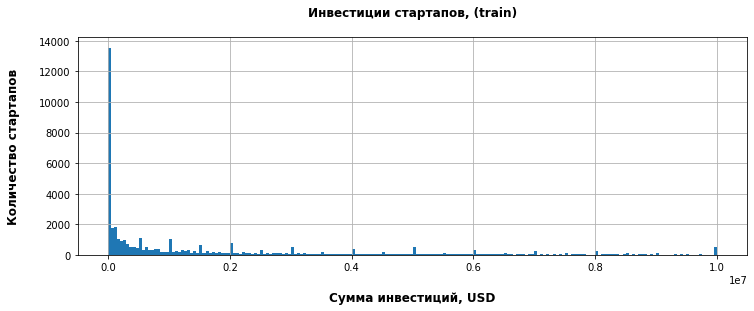

In [69]:
print(train['funding_total_usd'].describe())
plt.figure(figsize=(12, 4))
train['funding_total_usd'].hist(bins=200,range=(0,10000000))
#plt.xlim(0, 100000)
plt.title("Инвестиции стартапов, (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nСумма инвестиций, USD", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

По такому графику можно понять только то, что  отдельные стартапы привлекают на порядки больше инвестиций, чем остальное подавляющее большинство.

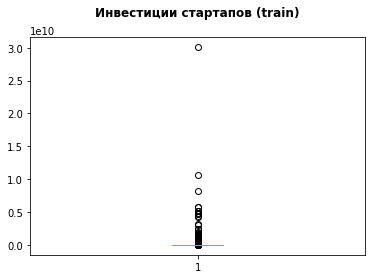

In [70]:
plt.boxplot(train['funding_total_usd'])
plt.title("Инвестиции стартапов (train)\n", fontsize=12, fontweight="bold")
plt.show()

Этот график подтверждает предыдущий вывод.

Теперь посмотрим этот же столбец в датафрейме test.

count    1.312500e+04
mean     1.329854e+07
std      8.288661e+07
min      0.000000e+00
25%      4.000000e+04
50%      9.500000e+05
75%      6.513865e+06
max      4.715000e+09
Name: funding_total_usd, dtype: float64


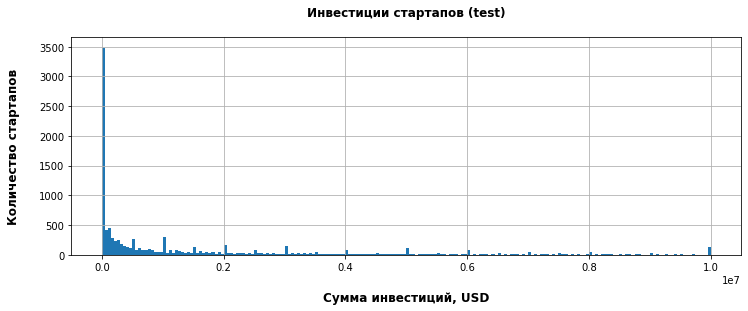

In [71]:
print(test['funding_total_usd'].describe())
plt.figure(figsize=(12, 4))
test['funding_total_usd'].hist(bins=200,range=(0,10000000))
#plt.xlim(0, 100000)
plt.title("Инвестиции стартапов (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nСумма инвестиций, USD", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

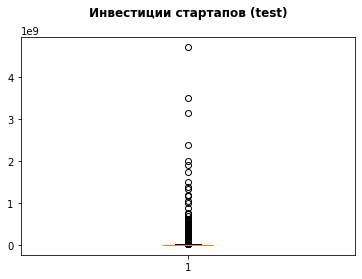

In [72]:
plt.boxplot(test['funding_total_usd'])
plt.title("Инвестиции стартапов (test)\n", fontsize=12, fontweight="bold")
plt.show()

То, что можно посчитать за выбросы, есть и в тестовой выборке тоже и их достаточно много. Удалять ничего не буду.

Рассмотрим столбец country_code.

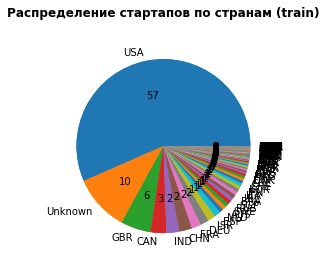

In [73]:
train['country_code'].value_counts().plot(kind='pie')
plt.title("Распределение стартапов по странам (train)\n", fontsize=12, fontweight="bold")
plt.pie(train['country_code'].value_counts().values, autopct='%.0f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

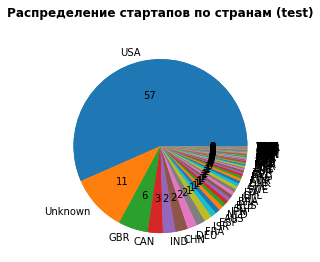

In [74]:
test['country_code'].value_counts().plot(kind='pie')
plt.title("Распределение стартапов по странам (test)\n", fontsize=12, fontweight="bold")
plt.pie(test['country_code'].value_counts().values, autopct='%.0f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

Больше половины стартапов из США, значительная часть без указания страны, также много стартапов из Великобритании, Канады, Индии и Китая.

В столбцах state_code, region, city слишком много разных значений. Визуализировать их смысла не вижу.

Рассмотрим столбец status датафрейма train.

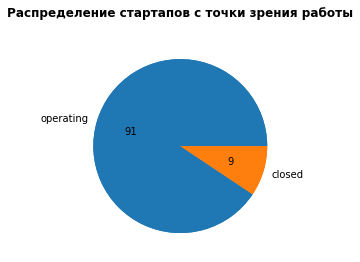

In [75]:
train['status'].value_counts().plot(kind='pie')
plt.title("Распределение стартапов с точки зрения работы\n", fontsize=12, fontweight="bold")
plt.pie(train['status'].value_counts().values, autopct='%.0f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

Закрылась только одна десятая всех стартапов.

Рассмотрим столбец funding_rounds.

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64


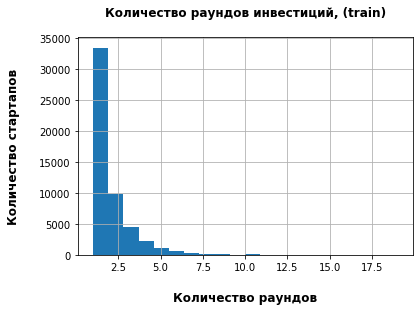

In [76]:
print(train['funding_rounds'].describe())
train['funding_rounds'].hist(bins=20)
plt.title("Количество раундов инвестиций, (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nКоличество раундов", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

count    13125.000000
mean         1.714438
std          1.318800
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: funding_rounds, dtype: float64


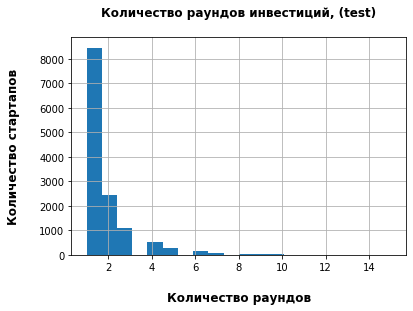

In [77]:
print(test['funding_rounds'].describe())
test['funding_rounds'].hist(bins=20)
plt.title("Количество раундов инвестиций, (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nКоличество раундов", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

В подавляющей части стартапов не больше двух раундов инвестиций.

Рассмотрим столбец founded_at с точки зрения года основания.

count                            52516
mean     2008-11-04 09:44:16.196206848
min                1970-02-05 00:00:00
25%                2006-10-01 00:00:00
50%                2010-10-01 00:00:00
75%                2013-01-01 00:00:00
max                2016-04-02 00:00:00
Name: founded_at, dtype: object


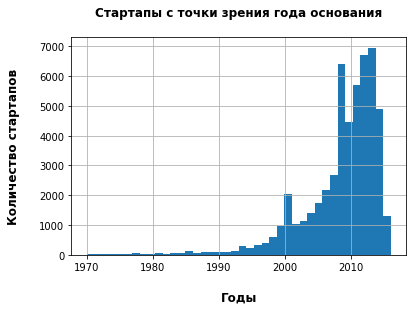

In [78]:
print(train['founded_at'].describe(datetime_is_numeric=True))
train['founded_at'].dt.year.hist(bins=40)
plt.title("Стартапы с точки зрения года основания\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

С 1970-х годов по 2010-е количество стартапов росло практически по экспоненте, с пиком в районе 2015 года.

Рассмотрим столбцы first_funding_at и last_funding_at в обоих датафреймах.

count                            52516
mean     2011-07-17 04:45:33.247010304
min                1977-05-15 00:00:00
25%                2009-10-12 00:00:00
50%                2012-07-23 00:00:00
75%                2014-04-01 00:00:00
max                2015-12-05 00:00:00
Name: first_funding_at, dtype: object


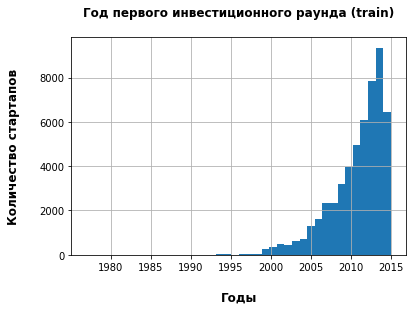

In [79]:
print(train['first_funding_at'].describe(datetime_is_numeric=True))
train['first_funding_at'].dt.year.hist(bins=40)
plt.title("Год первого инвестиционного раунда (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

count                            52516
mean     2012-06-27 16:29:42.313961472
min                1977-05-15 00:00:00
25%                2011-02-01 00:00:00
50%                2013-08-30 00:00:00
75%                2014-11-17 00:00:00
max                2015-12-07 00:00:00
Name: last_funding_at, dtype: object


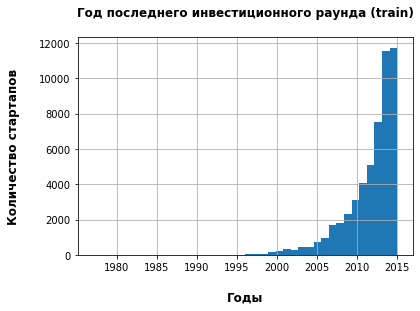

In [80]:
print(train['last_funding_at'].describe(datetime_is_numeric=True))
train['last_funding_at'].dt.year.hist(bins=40)
plt.title("Год последнего инвестиционного раунда (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

count                         13125
mean     2011-07-23 20:54:08.640000
min             1973-04-15 00:00:00
25%             2009-11-16 00:00:00
50%             2012-08-01 00:00:00
75%             2014-04-01 00:00:00
max             2015-12-03 00:00:00
Name: first_funding_at, dtype: object


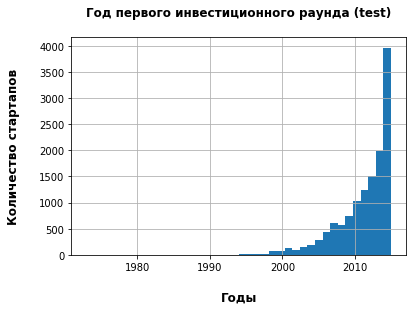

In [81]:
print(test['first_funding_at'].describe(datetime_is_numeric=True))
test['first_funding_at'].dt.year.hist(bins=40)
plt.title("Год первого инвестиционного раунда (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

count                            13125
mean     2012-06-16 05:03:41.348571392
min                1973-04-15 00:00:00
25%                2011-01-10 00:00:00
50%                2013-08-21 00:00:00
75%                2014-11-11 00:00:00
max                2015-12-12 00:00:00
Name: last_funding_at, dtype: object


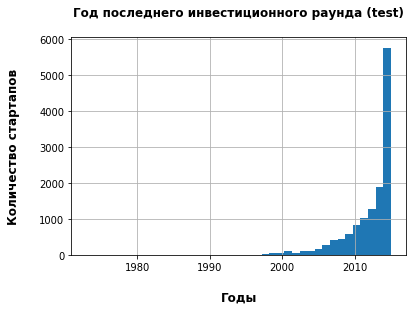

In [82]:
print(test['last_funding_at'].describe(datetime_is_numeric=True))
test['last_funding_at'].dt.year.hist(bins=40)
plt.title("Год последнего инвестиционного раунда (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

Графики в целом похожи на график года основания стартапа. Для графиков последнего раунда значения чуть сдвинуты вправо. В остальном не вижу, какую ещё полезную информацию отсюда можно получить.

Рассмотрим столбец closed_at за вычетом 2018-01-01, даты снятия информации.

count                             4917
mean     2012-01-16 16:14:21.012812800
min                1983-10-06 00:00:00
25%                2009-09-18 00:00:00
50%                2012-09-15 00:00:00
75%                2015-04-23 00:00:00
max                2017-10-21 00:00:00
Name: closed_at, dtype: object


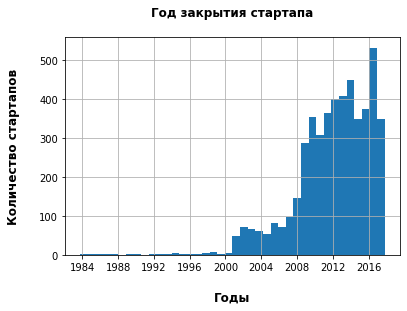

In [83]:
print(train[train['closed_at'].dt.year < 2018]['closed_at'].describe(datetime_is_numeric=True))
train[train['closed_at'].dt.year < 2018]['closed_at'].hist(bins=40)
plt.title("Год закрытия стартапа\n", fontsize=12, fontweight="bold")
plt.xlabel("\nГоды", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

В целом график похож на график открывшихся стартапов по годам. С ростом числа стартапов росло и число закрывшихся стартапов.

Рассмотрим столбец lifetime датафрейма test.

count    13125.000000
mean      3097.609524
std       2128.356554
min         52.000000
25%       1726.000000
50%       2526.000000
75%       3866.000000
max      17167.000000
Name: lifetime, dtype: float64


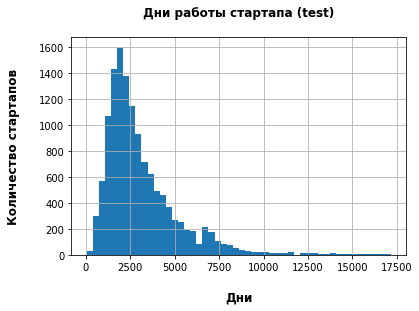

In [84]:
print(test['lifetime'].describe(datetime_is_numeric=True))
test['lifetime'].hist(bins=50)
plt.title("Дни работы стартапа (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДни", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

Это похоже на распределение Пуассона с пиком около 2000 дней.

Теперь рассмотрим этот же параметр для добавленного нами столбца в датафрейме train.

count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64


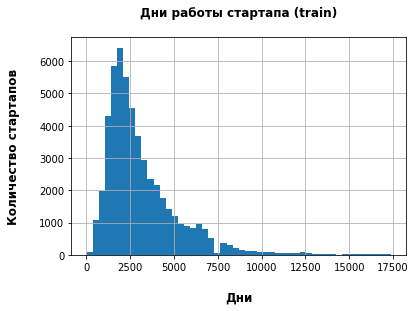

In [85]:
print(train['lifetime'].describe(datetime_is_numeric=True))
train['lifetime'].hist(bins=50)
plt.title("Дни работы стартапа (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДни", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

График похож на график датафрейма test, как и должно было получится. 

Посколько в дальнейшем будем использовать phik, а phik не работает с датами, то добавим столбец days_between_rounds в оба датафрейма.

In [86]:
train['days_between_rounds']  = (train['last_funding_at'] - train['first_funding_at']).dt.days

count    52516.000000
mean       346.488994
std        688.604389
min          0.000000
25%          0.000000
50%          0.000000
75%        427.000000
max      10807.000000
Name: days_between_rounds, dtype: float64


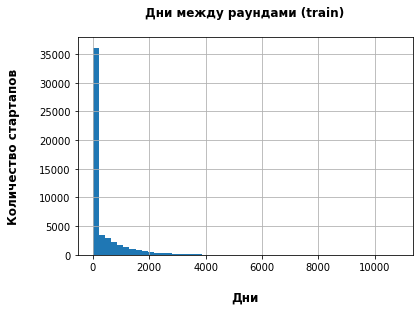

In [87]:
print(train['days_between_rounds'].describe(datetime_is_numeric=True))
train['days_between_rounds'].hist(bins=50)
plt.title("Дни между раундами (train)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДни", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

В большинстве случаев ноль дней поскольку был только один раунд.

In [88]:
test['days_between_rounds']  = (test['last_funding_at'] - test['first_funding_at']).dt.days

count    13125.000000
mean       328.339962
std        658.073065
min          0.000000
25%          0.000000
50%          0.000000
75%        391.000000
max       7038.000000
Name: days_between_rounds, dtype: float64


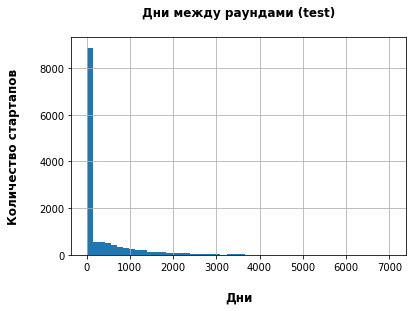

In [89]:
print(test['days_between_rounds'].describe(datetime_is_numeric=True))
test['days_between_rounds'].hist(bins=50)
plt.title("Дни между раундами (test)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДни", fontsize=12, fontweight="bold")
plt.ylabel("Количество стартапов\n",  fontsize=12, fontweight="bold")
plt.show()

Для датафрейма test примерно то же самое.

Есть слишком разных категорий, записанных черех знак "|". Оставим только первую, и скорее всего главную категорию.

In [90]:
test['category_list'] = test['category_list'].str.split('|').str[0]

In [91]:
test['category_list'].sample(7)

6676          Fashion
7234         Exercise
11994      E-Commerce
9465          Android
6013          Android
319      File Sharing
8425             Apps
Name: category_list, dtype: object

In [92]:
train['category_list'] = train['category_list'].str.split('|').str[0]

In [93]:
train['category_list'].sample(7)

48003    Enterprise Software
43623      Business Services
8399                 Unknown
24603                 Mobile
48629             Networking
35208           Broadcasting
7997     Health and Wellness
Name: category_list, dtype: object

Проверим связи признаков на мультиколлинеарность.  
Удалим столбцы с датой и столбцы с названием.  

In [94]:
train_selection = train.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)

In [95]:
interval_cols = ['funding_total_usd', 'funding_rounds', 'days_between_rounds' ,'lifetime']

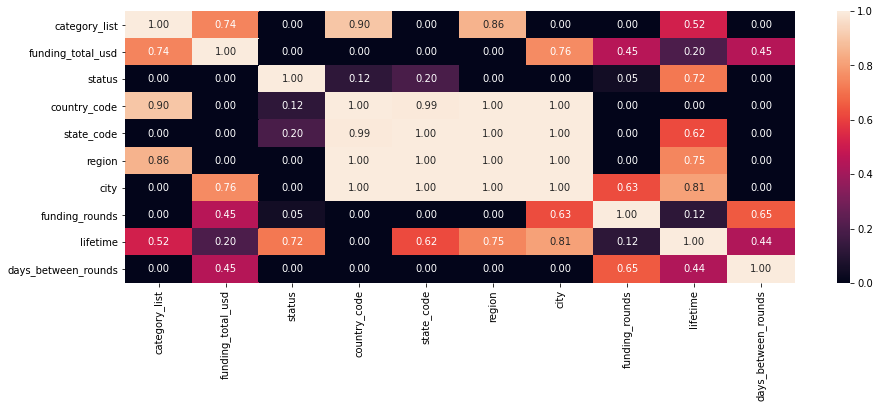

In [96]:
ig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train_selection.sample(1000).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Это первый вариант phik-матрицы.  
Видим мультиколлинеарность признаков, все признаки относящиеся к месторасположению - страна и другие. Их придется убрать. 

In [97]:
#со страной, без категорий
train_selection = train.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'state_code','region','city','category_list'], axis=1)

In [98]:
train_selection.sample(5)

,funding_total_usd,status,country_code,funding_rounds,lifetime,days_between_rounds
52161,1.500000e+04,operating,ARG,1,3068,0
32037,3.000000e+07,operating,FRA,1,6575,0
37097,8.885317e+06,operating,GBR,2,2506,589
22365,4.030000e+05,operating,USA,2,4383,876
25860,8.467397e+06,operating,CAN,2,2905,350


In [99]:
interval_cols = ['funding_total_usd', 'funding_rounds', 'days_between_rounds' ,'lifetime']

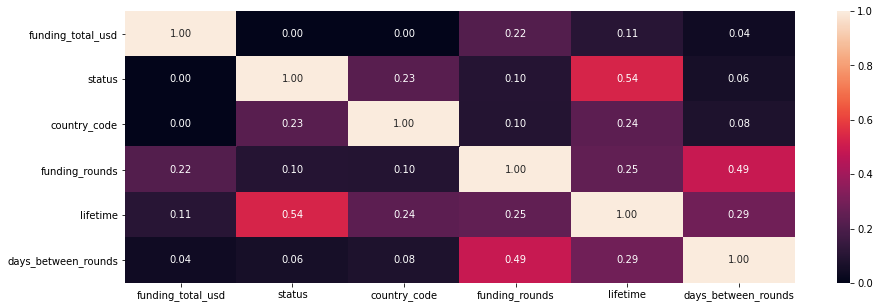

In [100]:
ig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train_selection.sample(50000).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Здесь мультиколлинеарности нет, между входными признаками коэффициенты корреляции меньше 0,9 по модулю.

In [101]:
#Изначально ещё вместо country_code было категория стартапа, но в дальнейшем при обучении jupiter с таким не справился
#и столбец category_list пришлось в любом случае убирать, даже приведенный к одной категории

Но при этом получилось мало признаков. Попробуем оставить дату в виде годов первого и последнего инвестиционного раунда.

In [102]:
train['first_funding_year'] = train['first_funding_at'].dt.year

In [103]:
train['last_funding_year'] = train['last_funding_at'].dt.year

Переопределяем train_selection.

In [104]:
train_selection = train.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'state_code','region','city','category_list'], axis=1)

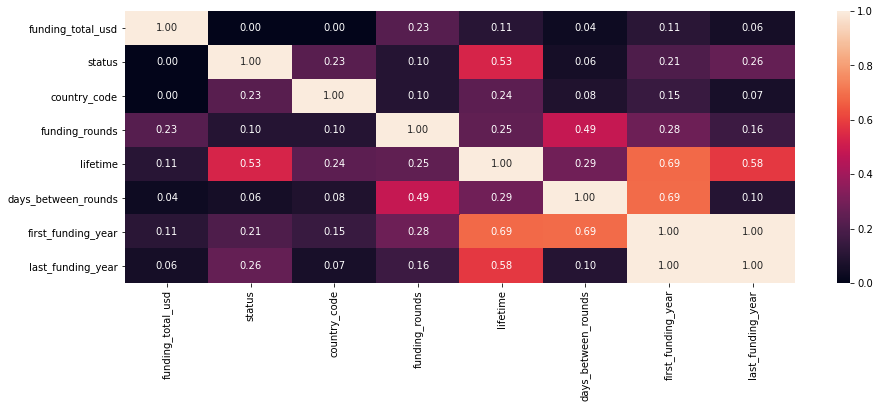

In [105]:
ig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train_selection.sample(50000).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Теперь придется убрать или first_funding_year, или last_funding_year. Уберем first_funding_year как имеющий чуть меньшую связь с целевый признаком stasus.

In [106]:
train_selection = train.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'state_code','region','city','category_list','first_funding_year'], axis=1)

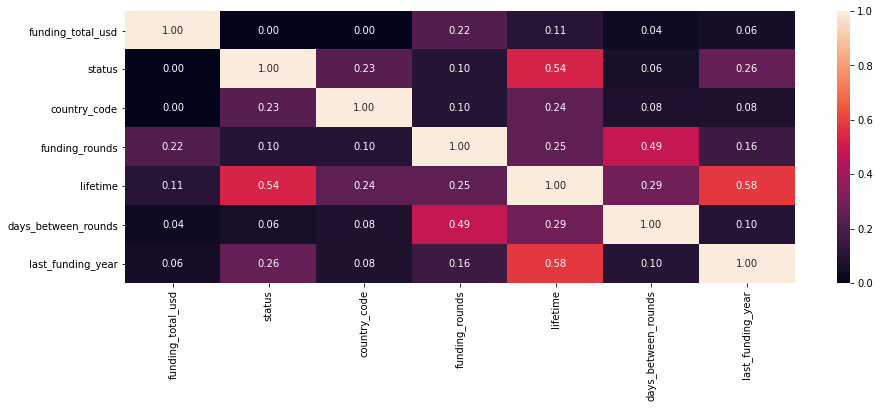

In [107]:
ig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train_selection.sample(50000).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Получили ситуацию без мультиколлинеарности.

Получили, что у целевого признака status:  
заметная связь с параметром lifetime,  
слабая связь с параметрами country_code и last_funding_year.  

По итогам исследовательского анализа можно сделать следующие выводы:  
бо́льшая часть стартапов привлекает суммы не более 10 млн. долларов,  
отдельные стартапы привлекают миллиарды или даже десятки миллиардов долларов,  
больше половины стартапов из США, также много стартапов из Великобритании, Канады, Индии и Китая,  
закрывается одна десятая часть стартапов,  
в подавляющей части стартапов не более двух раундов инвестиций,  
начиная с 1970-х годов по 2010-е количество стартапов росло по экспоненте, с пиком в районе 2015 года.  



### Подготовка данных 

По аналогии с train_selection создадим столбец test_selection.

In [108]:
test['first_funding_year'] = test['first_funding_at'].dt.year

In [109]:
test['last_funding_year'] = test['last_funding_at'].dt.year

In [110]:
#это вариант для столбца с годом
test_selection = test.drop(['name',  'first_funding_at', 'last_funding_at',  'state_code','region','city','category_list', 'first_funding_year'], axis=1)

In [111]:
test_selection.sample(7)

,funding_total_usd,country_code,funding_rounds,lifetime,days_between_rounds,last_funding_year
4464,62500000.0,USA,5,4018,2536,2013
12535,44300000.0,Unknown,2,11688,61,2014
4493,2600000.0,CAN,2,2192,336,2015
2358,8000000.0,USA,1,7670,0,2014
5339,5000000.0,USA,1,2572,0,2011
2273,6800000.0,USA,3,5814,1950,2009
12176,413400.0,DEU,3,1508,444,2015


In [112]:
# создаём списки с названиями признаков
ohe_columns = [
    #'category_list'#, 
    'country_code'#,
    #'status' 
]
ord_columns = [
 
]
num_columns = [
    'funding_total_usd',
    'funding_rounds', 
    'lifetime',
    'days_between_rounds' ,
    'last_funding_year'
] 

In [113]:
#создаём пайплайн для подготовки признаков из списка ohe_columns

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first' ))
    ]
    )

In [114]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [115]:
# создаём итоговый пайплайн: подготовка данных и модель
RANDOM_STATE = 42
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [116]:
param_grid = [
 # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='lbfgs',
                                      penalty= 'l2')
                  ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

На этом этапе было проделаны шаги по созданию пайплайна и созданы словари для трёх моделей.

### Обучение моделей

В качестве метрики будем использовать f1-score.

In [117]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1_weighted',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [118]:
X_train = train_selection.drop(columns=['status'], axis=1)

In [119]:
y_train = train_selection['status']

In [120]:
X_test = test_selection

In [121]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['country_code']),
                                                                              ('num',
                                                                               StandardScaler()...
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 5),
                                         'models__max_features': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1_weighted')

In [122]:
print('Лучшая модель и её параметры:\n\n',randomized_search.best_estimator_)  

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code']),
                                                 ('num', StandardScaler(),
                                                  ['funding_total_usd',
                        

In [123]:
print(f'Значение f1 лучшей модели: {randomized_search.best_score_:.3f}')

Значение f1 лучшей модели: 0.970


In [124]:
#без добавления last_funding_year было 0,94, оставляю этот вариант

In [125]:
y_test_text_result = randomized_search.predict(X_test)

In [126]:
y_test_text_result_df = pd.DataFrame(y_test_text_result, columns=['status'])

In [127]:
y_test_text_result_df['name'] = test['name']

In [128]:
y_test_text_result_df.sample(7)

,status,name
7925,closed,MeetMe
3231,operating,ABODO
5042,operating,AromaPass
10450,operating,shopkick
115,operating,GoAlbert
8413,operating,OneSpace
9805,operating,AppSame


In [129]:
y_test_text_result_df = y_test_text_result_df.iloc[:,[1,0]]

Сохрание результата в файл по образцу.

In [130]:
y_test_text_result_df.to_csv('result_new.csv', index=False)

Ипользовался один общий пайплайн, были обучены три модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression().   
Лучшей моделью оказалась KNeighborsClassifier, метод k-ближайших соседей, k получилось равным 4. В качестве метрики использовалась f1. Метрика лучшей модели 0,970 на тренировочной выборке.  
Предсказания по тестовой выборке сохранены в отдельный файл.

### Анализ важности признаков

In [131]:
explainer = shap.KernelExplainer(randomized_search.predict_proba, X_test[:100],keep_index=True)

In [132]:
shap_values = explainer(X_test[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

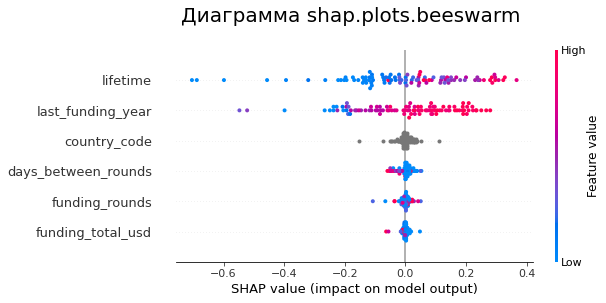

In [133]:
plt.title("Диаграмма shap.plots.beeswarm \n",fontsize=20)
shap.plots.beeswarm(shap_values[:,:,1], max_display=16) 

Признаки расположены сверху вних в порядке убывания средних SHAP‑значений, т.е. вклада каждого признака в предсказания. Красные точки справа от вертикальной оси говорят о том, что признак склоняет модель отнести объекты к классу 1. Синие точки слева от вертикальной оси говорит о том, что признак склоняет модель отнести объекты к классу 0.  
Цвет точки отражает значения каждого признака объекта, чем краснее точка тем больше признак.
Поскольку в нашем случае 1 соответствует работе стартапа, а 0 закрытию стартапа, то можно сказать что наиболее важные признаки это lifetime и last_funding_year.
Большие значения lifetime и last_funding_year склоняют модель к значению operating.  
И наоборот низкие значения lifetime и last_funding_year склоняют модель к значению closed. В большей степени это проявляется для признака lifetime.  
Остальные признаки вносят существенно меньший вклад в предсказание модели.



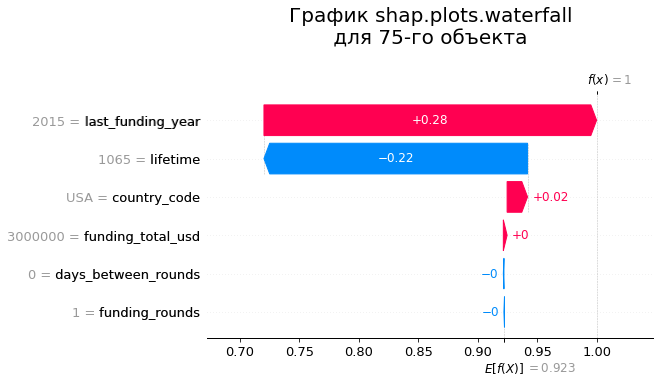

In [136]:
plt.title("График shap.plots.waterfall\n для 75-го объекта \n",fontsize=20)
shap.plots.waterfall(shap_values[75,:,1]) 

График shap.plots.waterfall визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете.  
Рассмотрим, например объект из 75-й строки.  
Наиболее влияет на классификацию 75-го объекта признак "last_funding_year", он перетяивает предсказание в сторону класса 1.   
Почти в такой же степени, но в сторону класса 0 перетягивает предсказание признак "lifetime".   
Очень незначительно в сторону класса 1 перетягивает предсказание признак "country_code".  
Остальные признаки в данном случае практически не влияют. 


Вывод по этапу "Анализ важности признаков".  
Было установлено, что наиболее влияют на предсказание модели признаки:
- lifetime,
- last_funding_year.  

Значительное меньшее влияние оказывают признаки:
- country_code,
- days_between_rounds,
- funding_rounds,
- funding_total_usd.

### Общий вывод

Целью задачи было создать модель для предсказания работы стартапов.  
Исходными данными были два файла с тренировочной и тестовой выборками, содержащие информацию о названии стартапа, отрасли, местонахождении стартапа (стране, регионе страны, городе), количестве раундов инвестиций, времени существования стартапа, дат первого и последнего раундов инвестиций.  
На этапе предобработки данных были заполнены пропуски, столбцы с датами приведены к нужному типу данных. 

Рассмотренные стартапы представляют собой следующее:  
бо́льшая часть стартапов привлекает суммы не более 10 млн. долларов,  
отдельные стартапы привлекают миллиарды или даже десятки миллиардов долларов,  
больше половины стартапов из США, также много стартапов из Великобритании, Канады, Индии и Китая,  
закрывается одна десятая часть стартапов,  
в подавляющей части стартапов не более двух раундов инвестиций,  
начиная с 1970-х годов по 2010-е количество стартапов росло по экспоненте, с пиком в районе 2015 года. 

Для поиска лучшей модели использовался один общий пайплайн с моделями DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression.  
Лучшей моделью оказалась KNeighborsClassifier, метод k-ближайших соседей, k получилось равным 4.  
Метрика лучшей модели 0,970 на тренировочной выборке.  
Результат предсказаний сохранён в отдельный файл для дальнейшей проверки через kaggle.